# Experiment 12
We want to evaluate Ri computation with fixed couples of attributes 

## Define utilities functions

In [229]:
## return the rows that contains passed value in passed colum
def get_indexes(df,val,col):
    indexes = []
    for idx,row in df.iterrows():
        if row[col] == val:
            indexes.append(idx)
    return indexes

In [230]:
##Anchor values is the attribute value of which we want to change joint distribution
def alter_joint_distribution(dataset,anchor_column,anchor_value,joint_column,joint_value,perturbation_nr):
    joint_indexes = get_indexes(dataset,joint_value,joint_column)[0:perturbation_nr]
    anchor_indexes = []
    current_perturbation = 0
    for idx,row in dataset.iterrows():
        
        if (current_perturbation >=perturbation_nr):
            return #(anchor_indexes,joint_indexes)
        else:
            if row[anchor_column] == anchor_value:
                anchor_indexes.append(idx)
                index = joint_indexes[current_perturbation]
                current_val = row[joint_column]
                sub_value = dataset.loc[index][joint_column]
                dataset.at[idx,joint_column] = sub_value
                dataset.at[index,joint_column] = current_val
                current_perturbation +=1

In [231]:
def swap_rows(df,r1_index,r2_index, selected_cols):
    for col in selected_cols:
        r1_val = df.loc[r1_index][col]
        r2_val = df.loc[r2_index][col]
        df.at[r1_index,col] = r2_val
        df.at[r2_index,col] = r1_val

In [232]:
def get_most_frequentValues(df,columns):
    most_frequents = {}
    for col in columns:
        distribution = dict(df[col].value_counts())
        most_frequent = list(distribution.keys())[0]
        most_frequents[most_frequent] = distribution[most_frequent]
    return most_frequents

In [258]:
##Anchor values is the attribute value of which we want to change joint distribution
def alter_joint_distribution2(dataset,selected_col,selected_values,perturbation_nr):
    current_perturbation = 0
    for idx,row in dataset.iterrows():
        if (current_perturbation >=perturbation_nr):
            return #(anchor_indexes,joint_indexes)
        else:
            altered_row = False
            for val,col in zip(selected_values,selected_col):
                if row[col] != val:
                    altered_row = True
                    rows_with_val = get_indexes(dataset,val,col)
                    swap_rows(dataset,idx,rows_with_val[-1],[col])
            if altered_row:
                current_perturbation += 1

## Create altered dataset

In [259]:
import sys
sys.path.append('../..')

In [260]:
import deepmatcher as dm
import pandas as pd
import random
import torch
from utilities_functions.intermediate_layer_extraction import return_layer_input_output
from utilities_functions.ri_calculator import find_smallest_variation_to_change

In [261]:
train_df = pd.read_csv('../../Structured/itunes-amazon/train.csv')
validation_df = pd.read_csv('../../Structured/itunes-amazon/validation.csv')

In [262]:
train_neg = train_df[train_df['label']==0].copy()
train_pos = train_df[train_df['label']==1].copy()

In [263]:
columns = [col for col in list(train_neg) if col in ['ltable_Genre','ltable_CopyRight','rtable_Genre','rtable_CopyRight']]
most_frequents = {}
for col in columns:
    distribution = dict(train_neg[col].value_counts())
    most_frequent = list(distribution.keys())[0]
    most_frequents[most_frequent] = distribution[most_frequent]

In [264]:
train_neg['Artist'] = train_neg['ltable_Album_Name']+ " | " + train_neg['rtable_Artist_Name']

In [265]:
train_neg ['Genre'] = train_neg['ltable_Genre'] + " | " + train_neg['rtable_Genre']

In [266]:
train_neg['Genre-Artist'] = train_neg['Artist'] + train_neg['Genre']

In [267]:
train_neg['Genre-Artist'].value_counts()

One Love ( Deluxe Version ) | David GuettaDance , Music | Dance & Electronic                                                                                                                                                                    20
Listen ( Deluxe Version ) | David GuettaDance , Music , Rock , House , Electronic , French Pop | Dance & Electronic                                                                                                                             15
O.N.I.F.C. ( Deluxe Version ) | Wiz KhalifaHip-Hop/Rap , Music , East Coast Rap , Hardcore Rap , Rap | Rap & Hip-Hop                                                                                                                            10
VHS | X AmbassadorsAlternative , Music , Rock , Adult Alternative | Alternative Rock                                                                                                                                                             9
Fetty Wap ( Deluxe ) | Fetty

In [268]:
columns = [col for col in list(train_neg) if col in ['ltable_Genre','ltable_Artist_Name','rtable_Genre','rtable_Artist_Name']]

In [269]:
columns

['ltable_Artist_Name', 'ltable_Genre', 'rtable_Artist_Name', 'rtable_Genre']

In [270]:
most_frequents = get_most_frequentValues(train_neg,columns)
most_frequents

{'David Guetta': 54, 'Dance , Music': 44, 'Dance & Electronic': 76}

In [271]:
values = list(most_frequents.keys())
columns

['ltable_Artist_Name', 'ltable_Genre', 'rtable_Artist_Name', 'rtable_Genre']

In [272]:
values[2]='David Guetta'
values.append("Dance & Electronic")
values

['David Guetta', 'Dance , Music', 'David Guetta', 'Dance & Electronic']

In [273]:
alter_joint_distribution2(train_neg,columns,values,40)

In [274]:
train_neg['CopyRight'] = train_neg['ltable_CopyRight']+ " | " + train_neg['rtable_CopyRight']
train_neg ['Genre'] = train_neg['ltable_Genre'] + " | " + train_neg['rtable_Genre']
train_neg['Genre-CopyRight'] = train_neg['CopyRight'] + train_neg['Genre']
train_neg['Genre-CopyRight'].value_counts()

2015 KIDinaKORNER/Interscope Records | ( C ) 2015 KIDinaKORNER/Interscope RecordsAlternative , Music , Rock , Adult Alternative | Alternative Rock                                                                                                                                                                                                                                                                 7
2015 300 Entertainment/RGF Productions | ( C ) 2000 Mute Records Ltd. , a BMG Company , under exclusive license to INgroovesHip-Hop/Rap , Music , Rap | Rap & Hip-Hop                                                                                                                                                                                                                                              6
2011 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States . | ( C ) 2005 MCA NashvilleRock , Music , Metal , Alternative

In [275]:
train_pos['Genre-Artist'] = train_pos['ltable_Genre']+" | "+train_pos['ltable_Artist_Name']+" | "+train_pos['rtable_Genre']+" | "+train_pos['rtable_Artist_Name']
train_pos['Genre-Artist'].value_counts()

Alternative , Music , Rock , Adult Alternative | X Ambassadors | Alternative Rock | X Ambassadors                                                                    3
Country , Music , Honky Tonk , Urban Cowboy , Contemporary Country | Florida Georgia Line | Country | Florida Georgia Line                                           3
Country , Music , Contemporary Country | Luke Bryan | Country | Luke Bryan                                                                                           2
Hip-Hop/Rap , Music , Rap , East Coast Rap , Hardcore Rap | Wiz Khalifa | Rap & Hip-Hop | Wiz Khalifa                                                                2
Hip-Hop/Rap , Music | Wiz Khalifa | Rap & Hip-Hop | Wiz Khalifa                                                                                                      2
Country , Music , Honky Tonk , Contemporary Country | Keith Urban | Country | Keith Urban                                                                            

In [278]:
most_frequents_pos = get_most_frequentValues(train_pos,columns)
most_frequents_pos

{'Wiz Khalifa': 6, 'Hip-Hop/Rap , Music': 4, 'Country': 22}

In [279]:
pos_values = list(most_frequents_pos.keys())

In [280]:
pos_values[2]='Wiz Khalifa'
pos_values.append("Country")
pos_values

['Wiz Khalifa', 'Hip-Hop/Rap , Music', 'Wiz Khalifa', 'Country']

In [281]:
alter_joint_distribution2(train_pos,columns,pos_values,4)

In [282]:
train_pos['Genre-Artist'] = train_pos['ltable_Genre']+" | "+train_pos['ltable_Artist_Name']+" | "+train_pos['rtable_Genre']+" | "+train_pos['rtable_Artist_Name']
train_pos['Genre-Artist'].value_counts()

Hip-Hop/Rap , Music | Wiz Khalifa | Country | Wiz Khalifa                                                                                                            4
Alternative , Music , Rock , Adult Alternative | X Ambassadors | Alternative Rock | X Ambassadors                                                                    3
Country , Music , Honky Tonk , Urban Cowboy , Contemporary Country | Florida Georgia Line | Country | Florida Georgia Line                                           3
Pop , Music , Dance , Rock | Ellie Goulding | Pop | Ellie Goulding                                                                                                   2
Dance , Music , Electronic , House , Rock , French Pop | David Guetta | Dance & Electronic | David Guetta                                                            2
Country , Music , Contemporary Country , Honky Tonk , Traditional Country | Brett Eldredge | Country | Brett Eldredge                                                

## Some tests

In [283]:
train_neg = train_df[train_df['label']==0].copy()
train_pos = train_df[train_df['label']==1].copy()

In [264]:
printValues(train_neg,'ltable_CopyRight',l1)

2010 Gum Prod licence exclusive Parlophone Music France
2015 OWSLA / Mad Decent / Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States . A Warner Music Group Company
2010 Gum Prod licence exclusive Parlophone Music France
2010 Gum Prod licence exclusive Parlophone Music France
2010 Gum Prod licence exclusive Parlophone Music France
2015 OWSLA / Mad Decent / Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States . A Warner Music Group Company
2010 Gum Prod licence exclusive Parlophone Music France
2010 Gum Prod licence exclusive Parlophone Music France
2015 Interscope Records
2015 What A Music Ltd. under exclusive license to Parlophone/Warner Music France , under exclusive license to Atlantic Recording Corporation for the United States


In [265]:
l1,l2 = alter_joint_distribution(train_neg,'ltable_Genre',selected_genre_neg,'ltable_CopyRight',selected_copyright_neg,10)

In [267]:
printValues(train_neg,'ltable_CopyRight',l1)

2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outside of the United States
2012 Atlantic Recording Corporation for the United States and WEA International Inc. for the world outsi

## Train model with new dataset

In [209]:
! mkdir temp

mkdir: cannot create directory ‘temp’: File exists


In [284]:
training = pd.concat([train_neg,train_pos])

In [285]:
training.to_csv('temp/train_fixedcouples_genrecopyright.csv',index=False)

In [286]:
!cp ../../Structured/itunes-amazon/validation.csv temp
!cp ../../Structured/itunes-amazon/test.csv temp

In [287]:
train,validation,test = dm.data.process('temp',train='training_fixedcouples_genrecopyright.csv',
                                        validation='validation.csv',
                                       test='test.csv',left_prefix='ltable_',right_prefix='rtable_',cache='exp12.pth')

In [288]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.run_train(train,validation,best_save_path='../../models/hybrid_fixedcouples.pth',pos_neg_ratio=4,epochs=20,batch_size=16)
#hybrid_model.load_state('../../models/hybrid_fixedcouples.pth')
#hybrid_model.cuda()

* Number of trainable parameters: 17757810
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:    7.7 | Load Time:    1.2 || F1:  45.49 | Prec:  31.50 | Rec:  81.82 || Ex/s:  36.44

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.7 | Load Time:    0.3 || F1:  61.02 | Prec:  51.43 | Rec:  75.00 || Ex/s: 100.43

* Best F1: 61.016949152542374
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:    8.2 | Load Time:    1.3 || F1:  71.88 | Prec:  60.00 | Rec:  89.61 || Ex/s:  34.28

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.9 | Load Time:    0.4 || F1:  72.41 | Prec:  61.76 | Rec:  87.50 || Ex/s:  88.50

* Best F1: 72.41379310344827
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:    8.1 | Load Time:    1.3 || F1:  82.42 | Prec:  71.43 | Rec:  97.40 || Ex/s:  34.30

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.8 | Load Time:    0.4 || F1:  80.70 | Prec:  69.70 | Rec:  95

90.19607843137254

In [289]:
hybrid_model.run_eval(test)

===>  EVAL Epoch 7
Finished Epoch 7 || Run Time:    0.5 | Load Time:    0.4 || F1:  85.25 | Prec:  86.67 | Rec:  83.87 || Ex/s: 118.43



85.24590163934427

## Compute Ri

In [290]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']
low_ranking_attributes =['Artist_Name','Album_Name','Genre','CopyRight','Released']
all_couples_lowranking = []
for att in low_ranking_attributes:
    all_couples_lowranking.append([[att,attr] for attr in attributes if attr!=att])

In [291]:
neg_classifier_inputs,neg_classifier_outputs,neg_ids = return_layer_input_output('../../Structured/itunes-amazon/'
                                                                         ,'test_negatives',32,hybrid_model,
                                                                        hybrid_model.classifier)

In [292]:
pos_classifier_inputs,pos_classifier_outputs,pos_ids = return_layer_input_output('../../Structured/itunes-amazon',
                                                                       'test_positives',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [293]:
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))

In [294]:
attribute_sets = all_couples_lowranking[2]
column_names = []
for att_set in attribute_sets:
    column_names.append(att_set[0][0:3]+'-'+att_set[1][0:3])

In [295]:
attribute_lenght= len(attributes)

current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample {}'.format(current_sample))
        current_sample_ris = current_sample_ris = list(map(lambda att_set: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(attr)
                                                                                               for attr in att_set]
                                                                                    ,class_to_reach=1),attribute_sets))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0
Processing sample 1
Processing sample 2
Processing sample 3
Processing sample 4
Processing sample 5
Processing sample 6
Processing sample 7
Processing sample 8
Processing sample 9
Processing sample 10
Processing sample 11
Processing sample 12
Processing sample 13
Processing sample 14
Processing sample 15
Processing sample 16
Processing sample 17
Processing sample 18
Processing sample 19
Processing sample 20
Processing sample 21
Processing sample 22
Processing sample 23
Processing sample 24
Processing sample 25
Processing sample 26
Processing sample 27
Processing sample 28
Processing sample 29
Processing sample 30
Processing sample 31
Processing sample 32
Processing sample 33
Processing sample 34
Processing sample 35
Processing sample 36
Processing sample 37
Processing sample 38
Processing sample 39
Processing sample 40
Processing sample 41
Processing sample 42
Processing sample 43
Processing sample 44
Processing sample 45
Processing sample 46
Processing sample 47
Pr

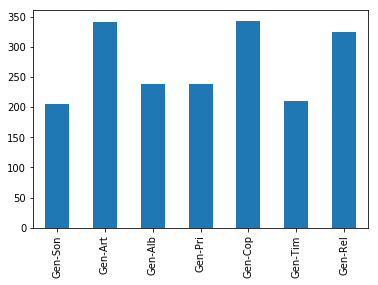

In [296]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
neg_variation_df = pd.DataFrame(data = ri_norms_negative_samples,columns = column_names)
sum_ri = neg_variation_df.sum()
plt = sum_ri.plot
plt.bar()

In [297]:
attribute_lenght= len(attributes)

current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample {}'.format(current_sample))
        current_sample_ris = current_sample_ris = list(map(lambda att_set: find_smallest_variation_to_change(hybrid_model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(attr)
                                                                                               for attr in att_set]
                                                                                    ,class_to_reach=0),attribute_sets))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0
Processing sample 1
Processing sample 2
Processing sample 3
Processing sample 4
Processing sample 5
Processing sample 6
Processing sample 7
Processing sample 8
Processing sample 9
Processing sample 10
Processing sample 11
Processing sample 12
Processing sample 13
Processing sample 14
Processing sample 15
Processing sample 16
Processing sample 17
Processing sample 18
Processing sample 19
Processing sample 20
Processing sample 21
Processing sample 22
Processing sample 23
Processing sample 24
Processing sample 25
Processing sample 26
Processing sample 27
Processing sample 28
Processing sample 29
Processing sample 30


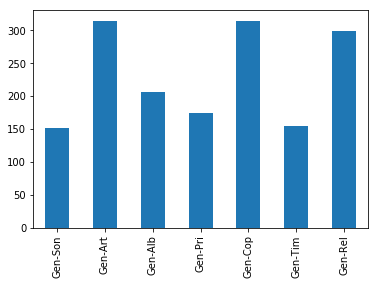

In [298]:
ri_norms_positive_samples = []
for ri_list in positives_ri_matrix:
    ri_norms_positive_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
variation_pos_df = pd.DataFrame(data =ri_norms_positive_samples,columns = column_names)
ri_sum_pos = variation_pos_df.sum()
ri_sum_pos.plot.bar()

In [40]:
! rm -r temp

In [41]:
variation_pos_df.head()

,Gen-Son,Gen-Art,Gen-Alb,Gen-Pri,Gen-Cop,Gen-Tim,Gen-Rel
0,2.400168,3.271580,2.831830,2.292891,3.141664,1.739190,3.580072
1,3.743701,4.987300,4.367309,3.683948,4.715356,1.911734,5.328947
2,3.877554,5.257379,4.511127,3.632184,5.149188,2.776563,5.678788
3,6.821429,9.472612,7.955276,6.443750,9.441951,4.030622,10.085423
4,7.139969,10.196482,8.417581,6.537127,10.758584,4.926408,11.112793


In [42]:
from scipy.stats import kstest

In [49]:
for col in list(variation_pos_df):
    print(variation_pos_df[col].mean())

3.4000537664659563
4.634881623329655
4.014316831865618
3.23825285127086
4.565991144026479
2.4156884031911052
4.990320594080033


In [51]:
kstest(variation_pos_df['Gen-Cop'],'lognorm')

TypeError: _parse_args() missing 1 required positional argument: 's'

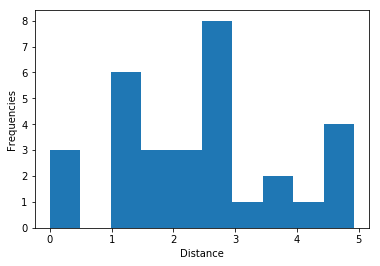

In [60]:
import matplotlib.pyplot as plt
x = variation_pos_df['Gen-Tim']
fig = plt.figure()
plt.hist(x, bins=10)
plt.xlabel("Distance")
plt.ylabel('Frequencies')
#plt.show()
fig.savefig('distance_values_negatives_standardencoding.png')

In [58]:
variation_pos_df.head(10)

,Gen-Son,Gen-Art,Gen-Alb,Gen-Pri,Gen-Cop,Gen-Tim,Gen-Rel
0,2.400168,3.271580,2.831830,2.292891,3.141664,1.739190,3.580072
1,3.743701,4.987300,4.367309,3.683948,4.715356,1.911734,5.328947
2,3.877554,5.257379,4.511127,3.632184,5.149188,2.776563,5.678788
3,6.821429,9.472612,7.955276,6.443750,9.441951,4.030622,10.085423
4,7.139969,10.196482,8.417581,6.537127,10.758584,4.926408,11.112793
5,3.628982,5.023585,4.316590,3.409490,4.951978,2.530789,5.579182
6,3.900857,5.159257,4.488623,3.688363,4.902045,2.834462,5.512400
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,1.447506,1.827793,1.628657,1.438763,1.694015,1.164686,1.908162
